<a href="https://colab.research.google.com/github/Saimon0007/Clustering-Datasets/blob/main/Clustered_chronic_kidney_disease_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**K-means Clusterng**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [ ]:
url ='https://raw.githubusercontent.com/muajnstu/Large_Scale_Implementation_of_DSK_Chain/refs/heads/main/Cleaned_Data/chronic_kidney_disease_processed.csv'
df = pd.read_csv(url)

X = df.drop(columns=['class'])
y = df['class']

X_0 = X[y == 0]
X_1 = X[y == 1]

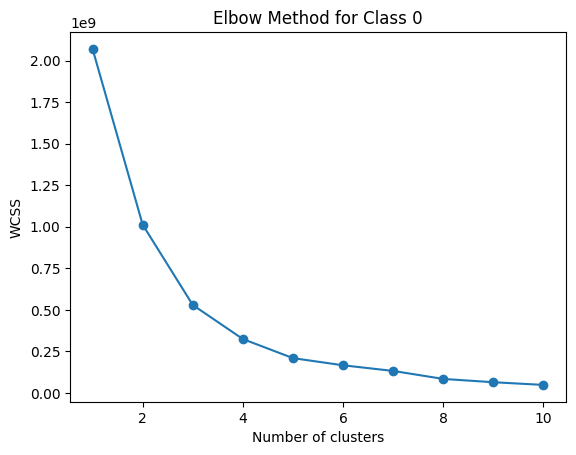

In [ ]:
wcss_0 = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_0)
    wcss_0.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss_0, marker='o')
plt.title('Elbow Method for Class 0')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

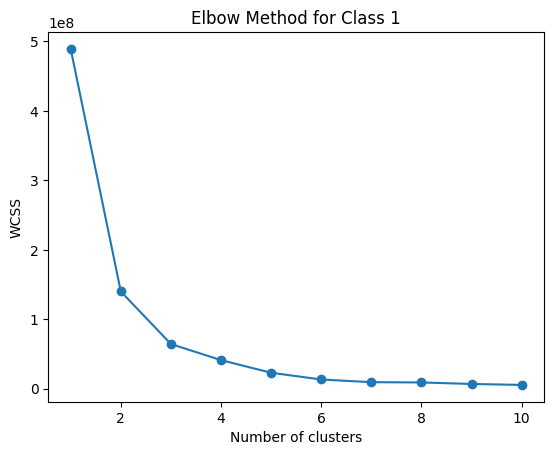

In [ ]:
wcss_1 = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_1)
    wcss_1.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss_1, marker='o')
plt.title('Elbow Method for Class 1')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
n_clusters_0 = 3   # <-- set based on elbow visualization
n_clusters_1 = 3   # <-- set based on elbow visualization

kmeans_0 = KMeans(n_clusters=n_clusters_0, random_state=42)
sub_labels_0 = kmeans_0.fit_predict(X_0)

kmeans_1 = KMeans(n_clusters=n_clusters_1, random_state=42)
sub_labels_1 = kmeans_1.fit_predict(X_1)

In [ ]:
counts_0 = np.bincount(sub_labels_0)
for i, count in enumerate(counts_0):
    print(f"Class 0 - Cluster {i}: {count} samples")

Class 0 - Cluster 0: 100 samples
Class 0 - Cluster 1: 15 samples
Class 0 - Cluster 2: 135 samples


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

def balanced_kmeans_postprocess(X, n_clusters=3, random_state=42, max_iters=5):
    """
    Runs KMeans then rebalances cluster sizes to be as even as possible by reassigning
    points that are more plausibly belonging to other centroids.
    Returns final_labels, diagnostics.
    """
    X = np.asarray(X)
    n_samples = X.shape[0]
    if n_samples < n_clusters:
        raise ValueError("n_samples < n_clusters; reduce n_clusters.")

    # scale
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # initial kmeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(Xs)
    centroids = kmeans.cluster_centers_

    # target sizes: distribute the remainder among first clusters
    base = n_samples // n_clusters
    rem = n_samples % n_clusters
    target_sizes = np.array([base + (1 if i < rem else 0) for i in range(n_clusters)])

    def cluster_counts(labs):
        vals, cnts = np.unique(labs, return_counts=True)
        counts = np.zeros(n_clusters, dtype=int)
        for v, c in zip(vals, cnts): counts[int(v)] = c
        return counts

    for it in range(max_iters):
        counts = cluster_counts(labels)
        surplus_clusters = np.where(counts > target_sizes)[0]
        deficit_clusters = np.where(counts < target_sizes)[0]

        if len(surplus_clusters) == 0 and len(deficit_clusters) == 0:
            break  # already balanced

        # recompute centroids for current labels (use means of Xs)
        centroids = np.vstack([Xs[labels == k].mean(axis=0) if np.sum(labels==k)>0 else centroids[k]
                               for k in range(n_clusters)])

        # For all points in surplus clusters, compute distance to current centroid and to each deficit centroid
        candidate_idx = np.isin(labels, surplus_clusters)
        idxs = np.where(candidate_idx)[0]
        if len(idxs) == 0:
            break

        dists_to_current = np.linalg.norm(Xs[idxs] - centroids[labels[idxs]], axis=1)
        # distances to each deficit centroid
        dists_to_deficits = pairwise_distances(Xs[idxs], centroids[deficit_clusters], metric='euclidean')

        # For each candidate point, find the best deficit centroid (min distance) and delta
        best_deficit_pos = np.argmin(dists_to_deficits, axis=1)
        best_deficit_cluster = deficit_clusters[best_deficit_pos]
        dist_to_best_deficit = dists_to_deficits[np.arange(len(idxs)), best_deficit_pos]
        delta = dists_to_current - dist_to_best_deficit  # positive -> closer to deficit than current

        # Build a dataframe of candidate moves prioritized by delta descending
        cand_df = pd.DataFrame({
            'idx': idxs,
            'current': labels[idxs],
            'best_deficit': best_deficit_cluster,
            'delta': delta
        }).sort_values('delta', ascending=False)

        # Now greedily move points to satisfy deficits, but only if delta > -inf (we allow moves even if slightly worse)
        # We'll pick highest delta moves but ensure we don't overfill deficits.
        counts = cluster_counts(labels)
        moved = 0
        for _, row in cand_df.iterrows():
            tgt = int(row['best_deficit'])
            cur = int(row['current'])
            if counts[cur] <= target_sizes[cur]:
                continue  # no surplus left in this source cluster
            if counts[tgt] >= target_sizes[tgt]:
                continue  # target filled
            # perform move
            labels[int(row['idx'])] = tgt
            counts[cur] -= 1
            counts[tgt] += 1
            moved += 1
            # if all deficits satisfied break early
            if np.all(counts >= target_sizes):
                break

        # if nothing moved, we may need to relax conditions and move nearest points regardless of delta
        if moved == 0:
            # compute full distances to all centroids and assign for deficits by closeness
            d_all = pairwise_distances(Xs[idxs], centroids, metric='euclidean')
            # create list of (idx position in idxs array, best_tgt, best_delta)
            alt = []
            for i_local, i_global in enumerate(idxs):
                cur = labels[i_global]
                # find among deficit_clusters the closest
                if len(deficit_clusters)==0:
                    break
                local_d = d_all[i_local, deficit_clusters]
                best_pos = np.argmin(local_d)
                tgt = deficit_clusters[best_pos]
                delta_local = d_all[i_local, cur] - local_d[best_pos]
                alt.append((i_global, cur, tgt, delta_local))
            # sort alt by delta descending
            alt_sorted = sorted(alt, key=lambda x: x[3], reverse=True)
            for i_global, cur, tgt, dlt in alt_sorted:
                if counts[cur] <= target_sizes[cur]:
                    continue
                if counts[tgt] >= target_sizes[tgt]:
                    continue
                labels[i_global] = tgt
                counts[cur] -= 1
                counts[tgt] += 1
                moved += 1
                if np.all(counts >= target_sizes):
                    break

        # if still not balanced, loop will continue and recompute centroids
    # final diagnostics
    final_counts = cluster_counts(labels)
    sil = silhouette_score(Xs, labels) if n_samples > n_clusters and len(np.unique(labels))>1 else float('nan')
    diagnostics = {
        'initial_n': n_samples,
        'n_clusters': n_clusters,
        'target_sizes': target_sizes.tolist(),
        'final_counts': final_counts.tolist(),
        'moves_done': int(moved),
        'final_silhouette': float(sil)
    }
    return labels, diagnostics

# -------------------------
# Example usage with your X_0 (pandas DataFrame or numpy array)
# -------------------------
# X_0 is the features for class 0
labels_balanced, diag = balanced_kmeans_postprocess(X_0, n_clusters=3, random_state=42, max_iters=8)
print("Diagnostics:", diag)

# Show final distribution
unique, counts = np.unique(labels_balanced, return_counts=True)
print("\nFinal counts per cluster:")
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")

# If you want labels attached to df_class0:
df_class0 = X_0.copy()
df_class0 = df_class0.reset_index(drop=True) if hasattr(df_class0, 'reset_index') else pd.DataFrame(X_0)
df_class0['Cluster_Label'] = labels_balanced
print("\nNew distribution (value_counts):")
print(df_class0['Cluster_Label'].value_counts().sort_index())


Diagnostics: {'initial_n': 250, 'n_clusters': 3, 'target_sizes': [84, 83, 83], 'final_counts': [84, 83, 83], 'moves_done': 55, 'final_silhouette': 0.07725298040742679}

Final counts per cluster:
Cluster 0: 84 samples
Cluster 1: 83 samples
Cluster 2: 83 samples

New distribution (value_counts):
Cluster_Label
0    84
1    83
2    83
Name: count, dtype: int64


In [ ]:
counts_1 = np.bincount(sub_labels_1)
for i, count in enumerate(counts_1):
    print(f"Class 1 - Cluster {i}: {count} samples")

Class 1 - Cluster 0: 40 samples
Class 1 - Cluster 1: 47 samples
Class 1 - Cluster 2: 63 samples


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, pairwise_distances

def balanced_kmeans_postprocess(X, n_clusters=3, random_state=42, max_iters=5):
    X = np.asarray(X)
    n_samples = X.shape[0]
    if n_samples < n_clusters:
        raise ValueError("n_samples < n_clusters; reduce n_clusters.")

    # Standardize
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # Initial KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(Xs)
    centroids = kmeans.cluster_centers_

    # Target sizes (balanced)
    base = n_samples // n_clusters
    rem = n_samples % n_clusters
    target_sizes = np.array([base + (1 if i < rem else 0) for i in range(n_clusters)])

    def cluster_counts(labs):
        vals, cnts = np.unique(labs, return_counts=True)
        counts = np.zeros(n_clusters, dtype=int)
        for v, c in zip(vals, cnts): counts[int(v)] = c
        return counts

    for it in range(max_iters):
        counts = cluster_counts(labels)
        surplus = np.where(counts > target_sizes)[0]
        deficit = np.where(counts < target_sizes)[0]
        if len(surplus) == 0 and len(deficit) == 0:
            break

        centroids = np.vstack([
            Xs[labels == k].mean(axis=0) if np.sum(labels == k) > 0 else centroids[k]
            for k in range(n_clusters)
        ])

        idxs = np.where(np.isin(labels, surplus))[0]
        if len(idxs) == 0:
            break

        d_cur = np.linalg.norm(Xs[idxs] - centroids[labels[idxs]], axis=1)
        d_def = pairwise_distances(Xs[idxs], centroids[deficit], metric='euclidean')

        best_def_pos = np.argmin(d_def, axis=1)
        best_def_cluster = deficit[best_def_pos]
        dist_to_best = d_def[np.arange(len(idxs)), best_def_pos]
        delta = d_cur - dist_to_best

        moves = pd.DataFrame({
            'idx': idxs,
            'current': labels[idxs],
            'best_deficit': best_def_cluster,
            'delta': delta
        }).sort_values('delta', ascending=False)

        counts = cluster_counts(labels)
        moved = 0
        for _, r in moves.iterrows():
            tgt = int(r['best_deficit'])
            cur = int(r['current'])
            if counts[cur] <= target_sizes[cur]: continue
            if counts[tgt] >= target_sizes[tgt]: continue
            labels[int(r['idx'])] = tgt
            counts[cur] -= 1
            counts[tgt] += 1
            moved += 1
            if np.all(counts >= target_sizes): break

        if moved == 0:  # no moves possible
            break

    final_counts = cluster_counts(labels)
    sil = silhouette_score(Xs, labels) if len(np.unique(labels)) > 1 else float('nan')
    diag = {
        'samples': n_samples,
        'target_sizes': target_sizes.tolist(),
        'final_counts': final_counts.tolist(),
        'silhouette': float(sil)
    }
    return labels, diag

# -----------------------------
# Assuming your dataset variables
# X = df.drop(columns=['class'])
# y = df['class']
X_1 = X[y == 1]

# Run reclustering for class 1
labels_balanced_1, diag1 = balanced_kmeans_postprocess(X_1, n_clusters=3, random_state=42, max_iters=8)
print("Diagnostics for Class 1:", diag1)

# Show final distribution
unique, counts = np.unique(labels_balanced_1, return_counts=True)
print("\nFinal counts per cluster (Class 1):")
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")

# Optional: attach to dataframe
df_class1 = X_1.copy()
df_class1['class'] = 1
df_class1['Cluster_Label'] = labels_balanced_1
print("\nNew distribution:")
print(df_class1['Cluster_Label'].value_counts().sort_index())


Diagnostics for Class 1: {'samples': 150, 'target_sizes': [50, 50, 50], 'final_counts': [50, 50, 50], 'silhouette': 0.01802990675674803}

Final counts per cluster (Class 1):
Cluster 0: 50 samples
Cluster 1: 50 samples
Cluster 2: 50 samples

New distribution:
Cluster_Label
0    50
1    50
2    50
Name: count, dtype: int64


In [ ]:
df_0 = X_0.copy()
df_0['class'] = 0
df_0['Cluster_Label'] = sub_labels_0

df_1 = X_1.copy()
df_1['class'] = 1
df_1['Cluster_Label'] = sub_labels_1

# Combine both datasets
final_df = pd.concat([df_0, df_1], ignore_index=True)

# Create unique cluster identifiers (combine class + subcluster)
final_df['Combined_Cluster'] = final_df['class'].astype(str) + '_' + final_df['Cluster_Label'].astype(str)

# Map to continuous cluster numbers starting from 0
unique_clusters = sorted(final_df['Combined_Cluster'].unique())
cluster_map = {old: new for new, old in enumerate(unique_clusters)}

# Assign new continuous labels
final_df['Cluster_Label'] = final_df['Combined_Cluster'].map(cluster_map)

# Drop helper columns (keep only desired ones)
final_df = final_df.drop(columns=['class', 'Combined_Cluster'])

# Save to CSV
final_df.to_csv('Clustered_Chronic_kidney_Data.csv', index=False)

print("✅ Final continuous cluster mapping applied successfully!")
print(final_df['Cluster_Label'].value_counts())


✅ Final continuous cluster mapping applied successfully!
Cluster_Label
2    135
0    100
5     63
4     47
3     40
1     15
Name: count, dtype: int64


DBSCAN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

In [ ]:
dbscan_0 = DBSCAN(eps=0.5, min_samples=5)
sub_labels_0 = dbscan_0.fit_predict(X_0)

dbscan_1 = DBSCAN(eps=0.5, min_samples=5)
sub_labels_1 = dbscan_1.fit_predict(X_1)

In [ ]:
unique_0, counts_0 = np.unique(sub_labels_0, return_counts=True)
for cluster, count in zip(unique_0, counts_0):
    print(f"Class 0 - Cluster {cluster}: {count} samples")

Class 0 - Cluster -1: 250 samples


In [ ]:
unique_1, counts_1 = np.unique(sub_labels_1, return_counts=True)
for cluster, count in zip(unique_1, counts_1):
    print(f"Class 1 - Cluster {cluster}: {count} samples")

Class 1 - Cluster -1: 150 samples


In [ ]:
df_0 = X_0.copy()
df_0['class'] = 0
df_0['Cluster_Label'] = sub_labels_0

df_1 = X_1.copy()
df_1['class'] = 1
df_1['Cluster_Label'] = sub_labels_1

# Combine both datasets
final_df = pd.concat([df_0, df_1], ignore_index=True)

# Create unique cluster identifiers (combine class + subcluster)
final_df['Combined_Cluster'] = final_df['class'].astype(str) + '_' + final_df['Cluster_Label'].astype(str)

# Map to continuous cluster numbers starting from 0
unique_clusters = sorted(final_df['Combined_Cluster'].unique())
cluster_map = {old: new for new, old in enumerate(unique_clusters)}

# Assign new continuous labels
final_df['Cluster_Label'] = final_df['Combined_Cluster'].map(cluster_map)

# Drop helper columns (keep only desired ones)
final_df = final_df.drop(columns=['class', 'Combined_Cluster'])

# Save to CSV
final_df.to_csv('Clustered_Chronic_Kidney_Disease_Data.csv', index=False)